In [42]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
%matplotlib inline

In [67]:
df = pd.read_csv('output.csv')
df.head(2)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,...,member_casual,file,month,day,year,day_of_week,start_hour,ride_length,ride_km,rider_speed
0,EC2DE40644C6B0F4,classic_bike,2022-05-23 23:06:58,2022-05-23 23:40:19,Wabash Ave & Grand Ave,TA1307000117,Halsted St & Roscoe St,TA1309000025,41.891466,-87.626761,...,member,202205-divvy-tripdata.csv,5,23,2022,Monday,23,33.35,6.30,0.0
1,1C31AD03897EE385,classic_bike,2022-05-11 08:53:28,2022-05-11 09:31:22,DuSable Lake Shore Dr & Monroe St,13300,Field Blvd & South Water St,15534,41.880958,-87.616743,...,member,202205-divvy-tripdata.csv,5,11,2022,Wednesday,8,37.90,0.61,0.0


             ride_length   ride_km  rider_speed
ride_length     1.000000  0.067843    -0.027525
ride_km         0.067843  1.000000     0.188422
rider_speed    -0.027525  0.188422     1.000000


Text(0.5, 1.0, 'Correlation Matrix of Ride Length, Ride Kilometers, and Rider Speed')

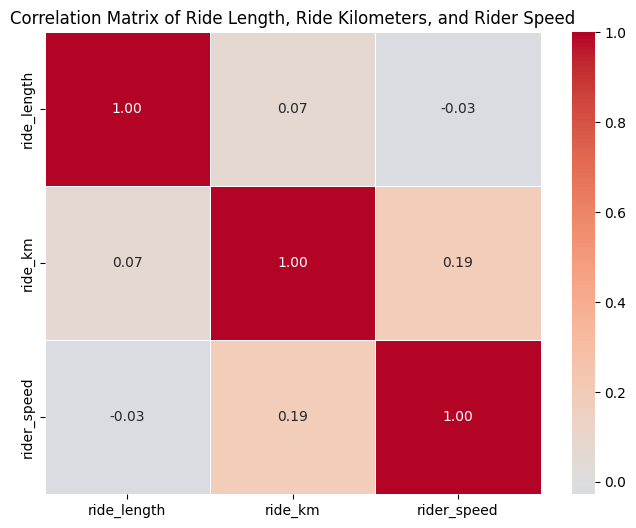

In [44]:
# Correlation Analysis: Identify relationships between variables. 
# Select the columns of interest
cols_of_interest = ['ride_length', 'ride_km', 'rider_speed']

# Calculate the correlation matrix
corr_matrix = df[cols_of_interest].corr()

print(corr_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Ride Length, Ride Kilometers, and Rider Speed')


t-test to compare means of ride_length, ride_km, or rider_speed between member_casual groups. This can help determine if there are statistically significant differences in these metrics between casual riders and annual members.

In [45]:
# define groups
casuals = df[df['member_casual'] == 'casual']
members = df[df['member_casual'] == 'member']

# Check for missing data in the two groups
print(f"Casual riders missing data: {casuals['ride_km'].isna().sum()}, {casuals['rider_speed'].isna().sum()}")
print(f"Annual members missing data: {members['ride_km'].isna().sum()}, {members['rider_speed'].isna().sum()}")
print()

# Handle missing data by either dropping these rows or imputing values. Here's an example of dropping:
casuals_clean = casuals.dropna(subset=['ride_km', 'rider_speed', 'ride_length'])
members_clean = members.dropna(subset=['ride_km', 'rider_speed', 'ride_length'])

# Initialize an empty list to store your results
results = []

# Loop through each column you want to test
# for col in ['ride_length', 'ride_km', 'rider_speed']:
#     casuals_col = casuals[col].dropna()
#     members_col = members[col].dropna()
#     t_stat, p_val = ttest_ind(casuals_col, members_col)
#     # Check if the result is significant
#     if p_val < 0.05:
#         sig = "Yes"
#     else:
#         sig = "no"
#     results.append([col, t_stat, p_val, sig])
    
for col in cols_of_interest:
    
    t_stat, p_val = ttest_ind(casuals_clean[col], members_clean[col])
    sig = "No" if p_val > 0.05 else "Yes"
    results.append([col, t_stat, p_val, sig])

# Convert your results into a DataFrame
df_results = pd.DataFrame(results, columns=['Variable', 'T-statistic', 'P-value', 'Significance'])

# Display the DataFrame
print(df_results)


Casual riders missing data: 4507, 4507
Annual members missing data: 867, 867

      Variable  T-statistic  P-value Significance
0  ride_length   151.035059      0.0          Yes
1      ride_km   107.883515      0.0          Yes
2  rider_speed  -196.981008      0.0          Yes


Null Hypothesis (H0): There is no association between rider type (casual or member) and the category of ride. This means that the rider type does not depend on the category of the ride; they are independent.

Alternative Hypothesis (H1): There is an association between rider type (casual or member) and the category of ride. This means that the rider type depends on the category of the ride; they are not independent.

In [46]:
"""Chi-square tests to understand if there's a significant association 
between rider type (casual/member) and the category of ride."""
contingency_table = pd.crosstab(df['member_casual'], df['rideable_type'])
chi2, p_val, dof, expected = chi2_contingency(contingency_table)
print( contingency_table )
print()
print(f'Chi-square statistic: {chi2}, P-value: {p_val}')
print('Expected Frequencies:')
print(expected)

rideable_type  classic_bike  docked_bike  electric_bike
member_casual                                          
casual              1216899       253174        1085009
member              1967359            0        1368324

Chi-square statistic: 365741.4602499161, P-value: 0.0
Expected Frequencies:
[[1381151.73481814  109812.61861032 1064117.64657154]
 [1803106.26518186  143361.38138968 1389215.35342846]]


In [47]:
# Post-hoc Analysis

from itertools import combinations
from statsmodels.sandbox.stats.multicomp import multipletests

# List of rideable types
rideable_types = df['rideable_type'].unique()

# Number of tests
num_tests = len(list(combinations(rideable_types, 2)))

# Bonferroni corrected alpha level
alpha_bonf = 0.05 / num_tests

# Initialize an empty list to store results
results = []

# Perform pairwise chi-square tests
for rideable_type1, rideable_type2 in combinations(rideable_types, 2):
    contingency_table_pair = df[df['rideable_type'].isin([rideable_type1, rideable_type2])]\
                             .groupby(['member_casual', 'rideable_type']).size().unstack(fill_value=0)
    chi2, p, _, _ = chi2_contingency(contingency_table_pair)
    results.append([rideable_type1, rideable_type2, chi2, p])

# Convert results into DataFrame
results_df = pd.DataFrame(results, columns=['Rideable Type 1', 'Rideable Type 2', 'Chi-square Stat', 'P-value'])

# Adjust p-values using Bonferroni correction
results_df['Adj P-value'] = multipletests(results_df['P-value'], method='bonferroni')[1]

print(results_df)


  Rideable Type 1 Rideable Type 2  Chi-square Stat  P-value  Adj P-value
0    classic_bike     docked_bike    365751.982024      0.0          0.0
1    classic_bike   electric_bike     20715.898318      0.0          0.0
2     docked_bike   electric_bike    285589.213439      0.0          0.0


The first row compares classic_bike and docked_bike. The chi-square statistic is very high and the p-value (both unadjusted and Bonferroni-adjusted) is 0. This indicates a statistically significant association between rider type (casual or member) and whether they use a classic bike or docked bike.

The second row compares classic_bike and electric_bike. Again, the chi-square statistic is quite high and the p-value is 0, indicating a statistically significant association between rider type and whether they use a classic bike or electric bike.

The third row compares docked_bike and electric_bike. The chi-square statistic is very high and the p-value is 0, indicating a statistically significant association between rider type and whether they use a docked bike or electric bike.

Cramer's V to understand strength of association. Cramér's V score was approximately 0.249. I would consider this a weak to moderate association. There is some association between rider type and the category of ride, but it's not a very strong association.

In [48]:
"""Cramer's V to understand strength of association"""

n = np.sum(contingency_table.values)  # Total number of observations
min_dim = min(contingency_table.shape) - 1  # Minus 1 from the minimum dimension of the table

# Calculate Cramer's V
cramer_v = np.sqrt((chi2/n) / min_dim)
print(f"Cramer's V: {cramer_v}")


Cramer's V: 0.22018364213713468


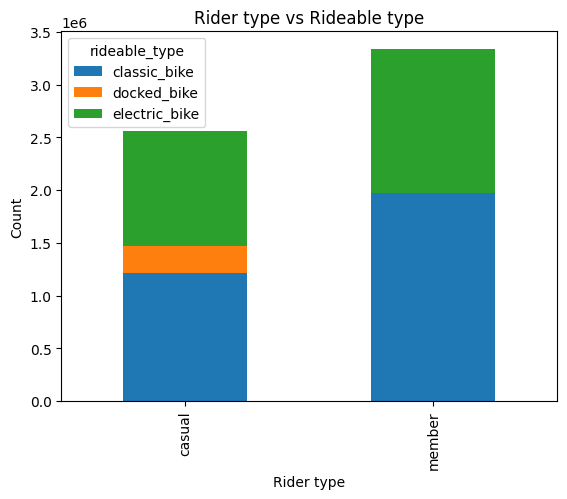

In [49]:

contingency_table.plot(kind="bar", stacked=True)
plt.title('Rider type vs Rideable type')
plt.xlabel('Rider type')
plt.ylabel('Count')
plt.show()


Temporal Analysis: 

I calculated the mean ride length for casual riders and members for each day of the week, then perform a two-sample T-test to check if the mean ride lengths are statistically significantly different, and plotted the results (see above).

The p-values are less than 0.05, this indicates strong evidence that the mean ride length is different for casual riders and members on a particular day of the week.

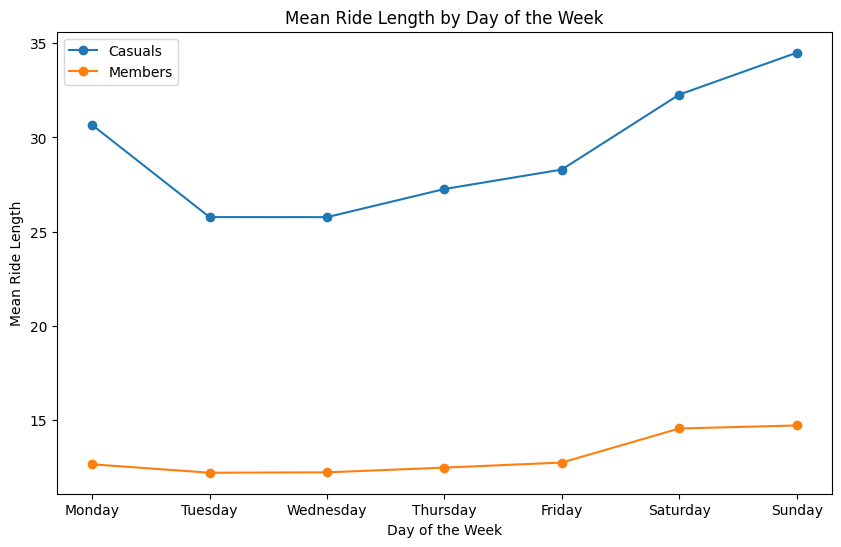

  day_of_week        p_value
0      Monday   0.000000e+00
1     Tuesday   0.000000e+00
2   Wednesday  6.192548e-261
3    Thursday  7.742194e-236
4      Friday   0.000000e+00
5    Saturday   0.000000e+00
6      Sunday   0.000000e+00


In [50]:
# Convert 'started_at' to datetime if it's not already
df['started_at'] = pd.to_datetime(df['started_at'])

# # Create 'day_of_week' column if it doesn't exist already
# df['day_of_week'] = df['started_at'].dt.day_name()

# split casual members
casuals = df[df['member_casual'] == 'casual']
members = df[df['member_casual'] == 'member']

# Create a list of days in order
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Store mean values and p-values for each day
mean_casuals = []
mean_members = []
p_values = []

for day in days:
    casuals_day = casuals[casuals['day_of_week'] == day]['ride_length'].dropna()
    members_day = members[members['day_of_week'] == day]['ride_length'].dropna()
    
    mean_casuals.append(casuals_day.mean())
    mean_members.append(members_day.mean())
    
    t_stat, p_val = ttest_ind(casuals_day, members_day, equal_var = False)
    p_values.append(p_val)

# Create a dataframe for easy plotting
df_means = pd.DataFrame({'day_of_week': days, 'mean_ride_length_casuals': mean_casuals, 'mean_ride_length_members': mean_members, 'p_value': p_values})

# Plot mean ride lengths
plt.figure(figsize=(10, 6))
plt.plot(df_means['day_of_week'], df_means['mean_ride_length_casuals'], marker='o', label='Casuals')
plt.plot(df_means['day_of_week'], df_means['mean_ride_length_members'], marker='o', label='Members')
plt.title('Mean Ride Length by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Mean Ride Length')
plt.legend()
plt.show()

# Print p-values
print(df_means[['day_of_week', 'p_value']])
